<a href="https://colab.research.google.com/github/ykitaguchi77/GravCont_classification_2/blob/main/Olympia_Hertel_estimation_RepVGG_20250320.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Olympia_Hertel_estimation_RepVGG-A2**

---



In [2]:
#google driveをcolabolatoryにマウント
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
from __future__ import print_function, division
!pip install torch_optimizer --q

import torch
import torch.nn as nn
import torch_optimizer as optim
import torch.utils.data as data
import numpy as np
import pandas as pd
import torchvision
from torchvision import datasets, models
from torchvision.transforms import v2
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.dataset import Subset
import matplotlib.pyplot as plt
import time
import os
import copy
import statistics
import math
import shutil

import glob
import random
import json
from PIL import Image
from tqdm import tqdm
%matplotlib inline
import seaborn as sns; sns.set()


#サポートパッチのインポート
from google.colab.patches import cv2_imshow
import cv2

plt.ion()   # interactive mode
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Set random seem for reproducibility
manualSeed = 1234
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)
torch.cuda.manual_seed(manualSeed)

torch.torch.backends.cudnn.benchmark = True
torch.torch.backends.cudnn.enabled = True


'''
黒の空白を挿入することにより500px*500pxの画像を生成
－－－－－－－－－－－－－－
データの構造
Olympia_dataset----Olympia_new/unilateral_25%_trainval----train (80%)
                                            |
                                            |--val (20%)


'''



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.9/55.9 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.9/61.9 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 109.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 83.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 55.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 89.3 MB/s eta 0:00:00
Random Seed:  1234


'\n黒の空白を挿入することにより500px*500pxの画像を生成\n－－－－－－－－－－－－－－\nデータの構造\nOlympia_dataset----Olympia_new/unilateral_25%_trainval----train (80%)\n                                            |\n                                            |--val (20%)\n\n\n'

#**Set Parameters**

In [4]:
path = '/content/drive/MyDrive/Deep_learning/Olympia_dataset/Olympia_new'
os.chdir(path)

# grav or cont, age, and sex
#NUM_CLASSES = 3

# contains train, val
#DATASET_PATH = r"./dataset_500px"
DATASET_PATH = r"./unilateral_25%_trainvaltest_250px"
#TRAIN_FOLDER_NAME = "train"
#VAL_FOLDER_NAME = "val"
#EFFICIENT_NET_NAME = "RepVGG-A2-train"
MODEL_PATH = "../RepVGG-A2-train.pth"
CSV_PATH = "./Hertel.csv"
#OPTIMIZER_PATH = "./optimizer_multi.pth"
#SEX_DICT_PATH = "gender_json"
#AGE_DICT_PATH = "age_json"
LOG_PATH = "./log_multi.txt"
ROC_PATH = "./roc_multi.png"
#CHECKPOINT_COUNT = 10
EPOCH = 100
PATIENCE = 20 #early stopping patience; how long to wait after last time validation loss improved.
BATCH_SIZE = 16

# transforms param
PX = 224
TRAIN_NORMALIZE_PARAM = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]
ROTATION_DEGREES = 5
TRAIN_CROP_SCALE =(0.75,1.0)

VAL_NORMALIZE_PARAM = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]

# トレーニング用変換
train_data_transforms = v2.Compose([
    # 基本的な前処理
    v2.ToImage(),
    v2.Resize(224, antialias=True),
    #v2.CenterCrop(224),


    # # 画質劣化シミュレーション（悪い画質への対策）- uint8形式で行う必要がある
    # v2.RandomApply([
    #     # JPEG圧縮シミュレーション
    #     v2.JPEG(quality=torch.randint(70, 100, (1,)).item()),
    # ], p=0.5),

    # ここでfloat変換を行う - JPEG後、他の変換前
    v2.ToDtype(torch.float32, scale=True),

    # # Reduced noise
    # v2.RandomApply([
    #     v2.GaussianNoise(mean=0.0, sigma=0.02, clip=True),  # Lower sigma
    # ], p=0.2),  # Lower probability

    # # Less blur
    # v2.RandomApply([
    #     v2.GaussianBlur(kernel_size=3, sigma=(0.1, 1.0)),  # Smaller kernel and range
    # ], p=0.2),

    #色調変換（照明やカメラ差異への対応）
    # v2.RandomPhotometricDistort(
    #     brightness=(0.9, 1.1),
    #     contrast=(0.9, 1.1),
    #     saturation=(0.9, 1.1),
    #     hue=(0, 0),
    #     p=0.2
    # ),

    # # 色調補正
    # v2.RandomAutocontrast(p=1.0),
    # v2.RandomEqualize(p=1.0),

    #幾何学的変換
    v2.RandomHorizontalFlip(),
    v2.RandomAffine(
        degrees=(-5, 5),
        translate=(0.05, 0.05),
        scale=(0.95, 1.05),
        fill=0
    ),

    # v2.RandomResizedCrop(224, scale=(0.85, 1.0), ratio=(0.9, 1.1), antialias=True),

    # 正規化
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
# 検証/テスト用変換
val_data_transforms = v2.Compose([
    v2.ToImage(),
    v2.Resize(224, antialias=True),
    # v2.CenterCrop(224),
    v2.ToDtype(torch.float32, scale=True),
    v2.RandomAutocontrast(p=1.0),
    v2.RandomEqualize(p=1.0),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

#**Create Datasets**

In [5]:
class Create_Datasets(Dataset):

    def __init__(self, folder_path, csv_path, transform):
        self.transform = transform
        self.folder_path = folder_path
        self.item_paths = []
        self.item_dict = {}
        self.df = pd.read_csv(csv_path)
        df = self.df

        k=0
        for image_name in os.listdir(folder_path):
            #base_name, ext = os.path.splitext(image_name) #フォルダより画像番号を抜き出す
            hertel = df[df['Image_path']==str(image_name)].iloc[0,4] #CSV上で一致した番号の画像についてHertel値を抜き出す
            self.item_paths.append([os.path.join(folder_path, image_name), hertel])
            item_paths = self.item_paths

    def __len__(self):
        return len(self.item_paths)

    def __getitem__(self, index):
        image_path = self.item_paths[index][0]
        pilr_image = Image.open(image_path).convert("RGB")
        tensor_image = self.transform(pilr_image).float()
        hertel = self.item_paths[index][1]
        target= torch.tensor([hertel]).float()
        return  tensor_image, target



train_dataset = Create_Datasets(DATASET_PATH+'/train', CSV_PATH, train_data_transforms)
val_dataset = Create_Datasets(DATASET_PATH+'/val', CSV_PATH, val_data_transforms)
test_dataset = Create_Datasets(DATASET_PATH+'/test', CSV_PATH, val_data_transforms)
train_loader = DataLoader(train_dataset, batch_size = BATCH_SIZE)
val_loader = DataLoader(val_dataset, batch_size = BATCH_SIZE)
test_loader = DataLoader(test_dataset, batch_size = 1)

print('train_dataset_size: ' +str(len(train_dataset)))
print('val_dataset_size: ' +str(len(val_dataset)))
print('test_dataset_size: ' +str(len(test_dataset)))


train_dataset_size: 3190
val_dataset_size: 744
test_dataset_size: 208


In [ ]:
######################
# Augmentation後の画像を表示
######################

import matplotlib.pyplot as plt
import numpy as np
import torch
from torchvision import transforms as T
import random

# Function to denormalize the images
def denormalize(tensor, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    """Denormalize a tensor image with mean and standard deviation."""
    tensor = tensor.clone()
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)
    return tensor

# Select random samples from training dataset
num_samples = 6
random_indices = random.sample(range(len(train_dataset)), num_samples)

# Set up the plot
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

# For each sample, get the image and target and display it
for i, idx in enumerate(random_indices):
    img, target = train_dataset[idx]

    # Denormalize the image
    img = denormalize(img)

    # Convert to numpy for display
    img_np = img.permute(1, 2, 0).numpy()

    # Clip values to [0, 1] range
    img_np = np.clip(img_np, 0, 1)

    # Display the image
    axes[i].imshow(img_np)
    axes[i].set_title(f"Hertel: {target.item():.2f}")
    axes[i].axis('off')

plt.tight_layout()
plt.suptitle("Sample Augmented Training Images", fontsize=16)
plt.subplots_adjust(top=0.9)
plt.show()

#**Test with early-stopping**

In [7]:
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement.
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss



def train_model(model, loss_func, batch_size, optimizer, patience, n_epochs, device):

    # to track the training loss as the model trains
    train_losses = []
    # to track the validation loss as the model trains
    valid_losses = []
    # to track the average training loss per epoch as the model trains
    avg_train_losses = []
    # to track the average validation loss per epoch as the model trains
    avg_valid_losses = []

    # initialize the early_stopping object
    early_stopping = EarlyStopping(patience=patience, verbose=True)

    for epoch in range(1, n_epochs + 1):

        ###################
        # train the model #
        ###################
        model.train() # prep model for training

        running_corrects, train_acc= 0, 0

        for batch, (image_tensor, target) in enumerate(train_loader, 1):
            # convert batch-size labels to batch-size x 1 tensor
            #target = target.squeeze(1)
            target = target.view(len(target), 1)

            image_tensor = image_tensor.to(device)
            target = target.to(device)

            # clear the gradients of all optimized variables
            optimizer.zero_grad()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(image_tensor)
            # calculate the loss
            loss = loss_func(output, target)
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # perform a single optimization step (parameter update)
            optimizer.step()

            # record training loss
            train_losses.append(loss.item())


        ######################
        # validate the model #
        ######################

        model.eval() # prep model for evaluation

        running_corrects, val_acc= 0, 0

        for image_tensor, target in val_loader:
            #target = target.squeeze(1)
            target = target.view(len(target), 1)

            image_tensor = image_tensor.to(device)
            target = target.to(device)
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(image_tensor)
            # calculate the loss
            # record validation loss
            valid_losses.append(loss.item())

        # print training/validation statistics
        # calculate average loss over an epoch
        train_loss = np.average(train_losses)
        valid_loss = np.average(valid_losses)
        avg_train_losses.append(train_loss)
        avg_valid_losses.append(valid_loss)

        epoch_len = len(str(n_epochs))

        print_msg = (f'Epoch: [{epoch:>{epoch_len}}/{n_epochs:>{epoch_len}}] ' +'\n'
                     f'train_loss: {train_loss:.5f} ' +'\n'
                     f'valid_loss: {valid_loss:.5f} ' )

        print(print_msg)

        # clear lists to track next epoch
        train_losses = []
        valid_losses = []

        # early_stopping needs the validation loss to check if it has decresed,
        # and if it has, it will make a checkpoint of the current model
        early_stopping(valid_loss, model)

        # コサインアニーリングスケジューラを更新 - early stoppingの後に配置
        scheduler.step()

        if early_stopping.early_stop:
            print("Early stopping")
            break

        print('')

    # load the last checkpoint with the best model
    model.load_state_dict(torch.load('checkpoint.pt'))

    return  model, avg_train_losses, avg_valid_losses

#**define RepVGG-A2**

In [8]:
def conv_bn(in_channels, out_channels, kernel_size, stride, padding, groups=1):
    result = nn.Sequential()
    result.add_module('conv', nn.Conv2d(in_channels=in_channels, out_channels=out_channels,
                                                  kernel_size=kernel_size, stride=stride, padding=padding, groups=groups, bias=False))
    result.add_module('bn', nn.BatchNorm2d(num_features=out_channels))
    return result

class RepVGGBlock(nn.Module):

    def __init__(self, in_channels, out_channels, kernel_size,
                 stride=1, padding=0, dilation=1, groups=1, padding_mode='zeros', deploy=False):
        super(RepVGGBlock, self).__init__()
        self.deploy = deploy
        self.groups = groups
        self.in_channels = in_channels

        assert kernel_size == 3
        assert padding == 1

        padding_11 = padding - kernel_size // 2

        self.nonlinearity = nn.ReLU()

        if deploy:
            self.rbr_reparam = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, stride=stride,
                                      padding=padding, dilation=dilation, groups=groups, bias=True, padding_mode=padding_mode)

        else:
            self.rbr_identity = nn.BatchNorm2d(num_features=in_channels) if out_channels == in_channels and stride == 1 else None
            self.rbr_dense = conv_bn(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, stride=stride, padding=padding, groups=groups)
            self.rbr_1x1 = conv_bn(in_channels=in_channels, out_channels=out_channels, kernel_size=1, stride=stride, padding=padding_11, groups=groups)
            print('RepVGG Block, identity = ', self.rbr_identity)


    def forward(self, inputs):
        if hasattr(self, 'rbr_reparam'):
            return self.nonlinearity(self.rbr_reparam(inputs))

        if self.rbr_identity is None:
            id_out = 0
        else:
            id_out = self.rbr_identity(inputs)

        return self.nonlinearity(self.rbr_dense(inputs) + self.rbr_1x1(inputs) + id_out)



#   This func derives the equivalent kernel and bias in a DIFFERENTIABLE way.
#   You can get the equivalent kernel and bias at any time and do whatever you want,
    #   for example, apply some penalties or constraints during training, just like you do to the other models.
#   May be useful for quantization or pruning.
    def get_equivalent_kernel_bias(self):
        kernel3x3, bias3x3 = self._fuse_bn_tensor(self.rbr_dense)
        kernel1x1, bias1x1 = self._fuse_bn_tensor(self.rbr_1x1)
        kernelid, biasid = self._fuse_bn_tensor(self.rbr_identity)
        return kernel3x3 + self._pad_1x1_to_3x3_tensor(kernel1x1) + kernelid, bias3x3 + bias1x1 + biasid

    def _pad_1x1_to_3x3_tensor(self, kernel1x1):
        if kernel1x1 is None:
            return 0
        else:
            return torch.nn.functional.pad(kernel1x1, [1,1,1,1])

    def _fuse_bn_tensor(self, branch):
        if branch is None:
            return 0, 0
        if isinstance(branch, nn.Sequential):
            kernel = branch.conv.weight
            running_mean = branch.bn.running_mean
            running_var = branch.bn.running_var
            gamma = branch.bn.weight
            beta = branch.bn.bias
            eps = branch.bn.eps
        else:
            assert isinstance(branch, nn.BatchNorm2d)
            if not hasattr(self, 'id_tensor'):
                input_dim = self.in_channels // self.groups
                kernel_value = np.zeros((self.in_channels, input_dim, 3, 3), dtype=np.float32)
                for i in range(self.in_channels):
                    kernel_value[i, i % input_dim, 1, 1] = 1
                self.id_tensor = torch.from_numpy(kernel_value).to(branch.weight.device)
            kernel = self.id_tensor
            running_mean = branch.running_mean
            running_var = branch.running_var
            gamma = branch.weight
            beta = branch.bias
            eps = branch.eps
        std = (running_var + eps).sqrt()
        t = (gamma / std).reshape(-1, 1, 1, 1)
        return kernel * t, beta - running_mean * gamma / std

    def repvgg_convert(self):
        kernel, bias = self.get_equivalent_kernel_bias()
        return kernel.detach().cpu().numpy(), bias.detach().cpu().numpy(),



class RepVGG(nn.Module):

    def __init__(self, num_blocks, num_classes=1000, width_multiplier=None, override_groups_map=None, deploy=False):
        super(RepVGG, self).__init__()

        assert len(width_multiplier) == 4

        self.deploy = deploy
        self.override_groups_map = override_groups_map or dict()

        assert 0 not in self.override_groups_map

        self.in_planes = min(64, int(64 * width_multiplier[0]))

        self.stage0 = RepVGGBlock(in_channels=3, out_channels=self.in_planes, kernel_size=3, stride=2, padding=1, deploy=self.deploy)
        self.cur_layer_idx = 1
        self.stage1 = self._make_stage(int(64 * width_multiplier[0]), num_blocks[0], stride=2)
        self.stage2 = self._make_stage(int(128 * width_multiplier[1]), num_blocks[1], stride=2)
        self.stage3 = self._make_stage(int(256 * width_multiplier[2]), num_blocks[2], stride=2)
        self.stage4 = self._make_stage(int(512 * width_multiplier[3]), num_blocks[3], stride=2)
        self.gap = nn.AdaptiveAvgPool2d(output_size=1)
        self.linear = nn.Linear(int(512 * width_multiplier[3]), num_classes)


    def _make_stage(self, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        blocks = []
        for stride in strides:
            cur_groups = self.override_groups_map.get(self.cur_layer_idx, 1)
            blocks.append(RepVGGBlock(in_channels=self.in_planes, out_channels=planes, kernel_size=3,
                                      stride=stride, padding=1, groups=cur_groups, deploy=self.deploy))
            self.in_planes = planes
            self.cur_layer_idx += 1
        return nn.Sequential(*blocks)

    def forward(self, x):
        out = self.stage0(x)
        out = self.stage1(out)
        out = self.stage2(out)
        out = self.stage3(out)
        out = self.stage4(out)
        out = self.gap(out)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


optional_groupwise_layers = [2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26]
g2_map = {l: 2 for l in optional_groupwise_layers}
g4_map = {l: 4 for l in optional_groupwise_layers}

def create_RepVGG_A0(deploy=False):
    return RepVGG(num_blocks=[2, 4, 14, 1], num_classes=1000,
                  width_multiplier=[0.75, 0.75, 0.75, 2.5], override_groups_map=None, deploy=deploy)

def create_RepVGG_A1(deploy=False):
    return RepVGG(num_blocks=[2, 4, 14, 1], num_classes=1000,
                  width_multiplier=[1, 1, 1, 2.5], override_groups_map=None, deploy=deploy)

def create_RepVGG_A2(deploy=False):
    return RepVGG(num_blocks=[2, 4, 14, 1], num_classes=1000,
                  width_multiplier=[1.5, 1.5, 1.5, 2.75], override_groups_map=None, deploy=deploy)

def create_RepVGG_B0(deploy=False):
    return RepVGG(num_blocks=[4, 6, 16, 1], num_classes=1000,
                  width_multiplier=[1, 1, 1, 2.5], override_groups_map=None, deploy=deploy)

def create_RepVGG_B1(deploy=False):
    return RepVGG(num_blocks=[4, 6, 16, 1], num_classes=1000,
                  width_multiplier=[2, 2, 2, 4], override_groups_map=None, deploy=deploy)

def create_RepVGG_B1g2(deploy=False):
    return RepVGG(num_blocks=[4, 6, 16, 1], num_classes=1000,
                  width_multiplier=[2, 2, 2, 4], override_groups_map=g2_map, deploy=deploy)

def create_RepVGG_B1g4(deploy=False):
    return RepVGG(num_blocks=[4, 6, 16, 1], num_classes=1000,
                  width_multiplier=[2, 2, 2, 4], override_groups_map=g4_map, deploy=deploy)


def create_RepVGG_B2(deploy=False):
    return RepVGG(num_blocks=[4, 6, 16, 1], num_classes=1000,
                  width_multiplier=[2.5, 2.5, 2.5, 5], override_groups_map=None, deploy=deploy)

def create_RepVGG_B2g2(deploy=False):
    return RepVGG(num_blocks=[4, 6, 16, 1], num_classes=1000,
                  width_multiplier=[2.5, 2.5, 2.5, 5], override_groups_map=g2_map, deploy=deploy)

def create_RepVGG_B2g4(deploy=False):
    return RepVGG(num_blocks=[4, 6, 16, 1], num_classes=1000,
                  width_multiplier=[2.5, 2.5, 2.5, 5], override_groups_map=g4_map, deploy=deploy)


def create_RepVGG_B3(deploy=False):
    return RepVGG(num_blocks=[4, 6, 16, 1], num_classes=1000,
                  width_multiplier=[3, 3, 3, 5], override_groups_map=None, deploy=deploy)

def create_RepVGG_B3g2(deploy=False):
    return RepVGG(num_blocks=[4, 6, 16, 1], num_classes=1000,
                  width_multiplier=[3, 3, 3, 5], override_groups_map=g2_map, deploy=deploy)

def create_RepVGG_B3g4(deploy=False):
    return RepVGG(num_blocks=[4, 6, 16, 1], num_classes=1000,
                  width_multiplier=[3, 3, 3, 5], override_groups_map=g4_map, deploy=deploy)


func_dict = {
'RepVGG-A0': create_RepVGG_A0,
'RepVGG-A1': create_RepVGG_A1,
'RepVGG-A2': create_RepVGG_A2,
'RepVGG-B0': create_RepVGG_B0,
'RepVGG-B1': create_RepVGG_B1,
'RepVGG-B1g2': create_RepVGG_B1g2,
'RepVGG-B1g4': create_RepVGG_B1g4,
'RepVGG-B2': create_RepVGG_B2,
'RepVGG-B2g2': create_RepVGG_B2g2,
'RepVGG-B2g4': create_RepVGG_B2g4,
'RepVGG-B3': create_RepVGG_B3,
'RepVGG-B3g2': create_RepVGG_B3g2,
'RepVGG-B3g4': create_RepVGG_B3g4,
}
def get_RepVGG_func_by_name(name):
    return func_dict[name]



#   Use this for converting a customized model with RepVGG as one of its components (e.g., the backbone of a semantic segmentation model)
#   The use case will be like
#   1.  Build train_model. For example, build a PSPNet with a training-time RepVGG as backbone
#   2.  Train train_model or do whatever you want
#   3.  Build deploy_model. In the above example, that will be a PSPNet with an inference-time RepVGG as backbone
#   4.  Call this func
#   ====================== the pseudo code will be like
#   train_backbone = create_RepVGG_B2(deploy=False)
#   train_backbone.load_state_dict(torch.load('RepVGG-B2-train.pth'))
#   train_pspnet = build_pspnet(backbone=train_backbone)
#   segmentation_train(train_pspnet)
#   deploy_backbone = create_RepVGG_B2(deploy=True)
#   deploy_pspnet = build_pspnet(backbone=deploy_backbone)
#   whole_model_convert(train_pspnet, deploy_pspnet)
#   segmentation_test(deploy_pspnet)
def whole_model_convert(train_model:torch.nn.Module, deploy_model:torch.nn.Module, save_path=None):
    all_weights = {}
    for name, module in train_model.named_modules():
        if hasattr(module, 'repvgg_convert'):
            kernel, bias = module.repvgg_convert()
            all_weights[name + '.rbr_reparam.weight'] = kernel
            all_weights[name + '.rbr_reparam.bias'] = bias
            print('convert RepVGG block')
        else:
            for p_name, p_tensor in module.named_parameters():
                full_name = name + '.' + p_name
                if full_name not in all_weights:
                    all_weights[full_name] = p_tensor.detach().cpu().numpy()
            for p_name, p_tensor in module.named_buffers():
                full_name = name + '.' + p_name
                if full_name not in all_weights:
                    all_weights[full_name] = p_tensor.cpu().numpy()

    deploy_model.load_state_dict(all_weights)
    if save_path is not None:
        torch.save(deploy_model.state_dict(), save_path)

    return deploy_model


#   Use this when converting a RepVGG without customized structures.
#   train_model = create_RepVGG_A0(deploy=False)
#   train train_model
#   deploy_model = repvgg_convert(train_model, create_RepVGG_A0, save_path='repvgg_deploy.pth')
def repvgg_model_convert(model:torch.nn.Module, build_func, save_path=None):
    converted_weights = {}
    for name, module in model.named_modules():
        if hasattr(module, 'repvgg_convert'):
            kernel, bias = module.repvgg_convert()
            converted_weights[name + '.rbr_reparam.weight'] = kernel
            converted_weights[name + '.rbr_reparam.bias'] = bias
        elif isinstance(module, torch.nn.Linear):
            converted_weights[name + '.weight'] = module.weight.detach().cpu().numpy()
            converted_weights[name + '.bias'] = module.bias.detach().cpu().numpy()
    del model

    deploy_model = build_func(deploy=True)
    for name, param in deploy_model.named_parameters():
        print('deploy param: ', name, param.size(), np.mean(converted_weights[name]))
        param.data = torch.from_numpy(converted_weights[name]).float()

    if save_path is not None:
        torch.save(deploy_model.state_dict(), save_path)

    return deploy_model





class mod_RepVGG(nn.Module):
    def __init__(self):
        super(mod_RepVGG, self).__init__()
        repVGG = model_ft
        self.repVGG = nn.Sequential(*list(model_ft.children())[:-1])
        self.dropout = nn.Dropout(0.3)  # ドロップアウト層を追加

        self.fc = nn.Linear(in_features=1408, out_features=1) #out_featuresを1に

    def forward(self, x):
        x = self.repVGG(x)
        x = torch.flatten(x, 1)
        x = self.dropout(x)  # ドロップアウトを適用
        x = self.fc(x)
        return x

In [9]:
from torch.optim.lr_scheduler import CosineAnnealingLR

def get_cosine_schedule_with_warmup(optimizer, num_warmup_epochs, num_training_epochs, min_lr=1e-6):
    """
    ウォームアップ付きコサインアニーリングスケジューラを作成
    """
    def lr_lambda(current_epoch):
        # ウォームアップ期間
        if current_epoch < num_warmup_epochs:
            return float(current_epoch) / float(max(1, num_warmup_epochs))
        # コサインアニーリング期間
        progress = float(current_epoch - num_warmup_epochs) / float(max(1, num_training_epochs - num_warmup_epochs))
        return max(min_lr, 0.5 * (1.0 + math.cos(math.pi * progress)))

    return torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)


#**ConvNetの調整**

In [10]:
model_ft = create_RepVGG_A2(deploy=False)
model_ft.load_state_dict(torch.load(MODEL_PATH))
model_ft = mod_RepVGG()

#GPU使用
model_ft = model_ft.to(device)

#損失関数を定義
loss_func = nn.MSELoss()

#Optimizer
#optimizer_ft = torch.optim.AdamW(model_ft.parameters(), 0.0002)

# 使用例
optimizer_ft = torch.optim.AdamW(model_ft.parameters(), 0.0002, weight_decay=1e-4)
scheduler = get_cosine_schedule_with_warmup(
    optimizer_ft,
    num_warmup_epochs=5,  # 最初の5エポックでウォームアップ
    num_training_epochs=EPOCH,
    min_lr=1e-6  # 最小学習率
)

RepVGG Block, identity =  None
RepVGG Block, identity =  None
RepVGG Block, identity =  BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
RepVGG Block, identity =  None
RepVGG Block, identity =  BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
RepVGG Block, identity =  BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
RepVGG Block, identity =  BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
RepVGG Block, identity =  None
RepVGG Block, identity =  BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
RepVGG Block, identity =  BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
RepVGG Block, identity =  BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
RepVGG Block, identity =  BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
RepVGG Block, identit

In [11]:
model, train_loss, valid_loss = train_model(model_ft, loss_func, BATCH_SIZE, optimizer_ft, PATIENCE, EPOCH, device)


Epoch: [  1/100] 
train_loss: 256.05773 
valid_loss: 253.73157 
Validation loss decreased (inf --> 253.731567).  Saving model ...

Epoch: [  2/100] 
train_loss: 37.47547 
valid_loss: 0.51556 
Validation loss decreased (253.731567 --> 0.515565).  Saving model ...

Epoch: [  3/100] 
train_loss: 11.23218 
valid_loss: 1.50013 
EarlyStopping counter: 1 out of 20

Epoch: [  4/100] 
train_loss: 10.37518 
valid_loss: 3.67732 
EarlyStopping counter: 2 out of 20

Epoch: [  5/100] 
train_loss: 10.72450 
valid_loss: 1.84190 
EarlyStopping counter: 3 out of 20

Epoch: [  6/100] 
train_loss: 10.06928 
valid_loss: 1.60580 
EarlyStopping counter: 4 out of 20

Epoch: [  7/100] 
train_loss: 10.18031 
valid_loss: 2.69179 
EarlyStopping counter: 5 out of 20

Epoch: [  8/100] 
train_loss: 10.30562 
valid_loss: 1.14473 
EarlyStopping counter: 6 out of 20

Epoch: [  9/100] 
train_loss: 9.42152 
valid_loss: 2.91909 
EarlyStopping counter: 7 out of 20

Epoch: [ 10/100] 
train_loss: 9.19689 
valid_loss: 1.84714

#**Draw Learning Curves**

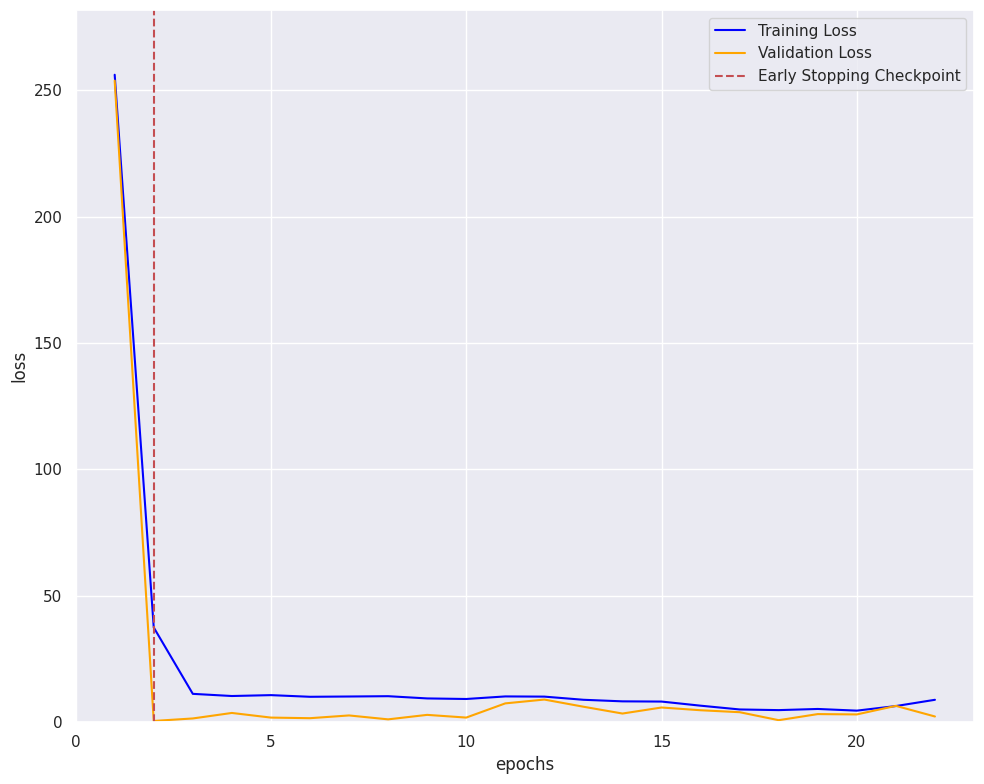

In [12]:
# visualize the loss as the network trained
fig = plt.figure(figsize=(10,8))
plt.plot(range(1,len(train_loss)+1),train_loss, label='Training Loss', color='blue')
plt.plot(range(1,len(valid_loss)+1),valid_loss,label='Validation Loss', color='orange')

# find position of lowest validation loss
minposs = valid_loss.index(min(valid_loss))+1
plt.axvline(minposs, linestyle='--', color='r',label='Early Stopping Checkpoint')

plt.xlabel('epochs')
plt.ylabel('loss')

# Set y-axis from 0 to the maximum loss value instead of 0 to 1.0
max_loss = max(max(train_loss), max(valid_loss))
plt.ylim(0, max_loss * 1.1)  # Add 10% padding to make the plot look better

plt.xlim(0, len(train_loss)+1)  # consistent scale
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
fig.savefig('loss_plot.png', bbox_inches='tight')

#**Evaluation using testset**

AveError: -2.241077872423025
StdError: 3.0250434758633524
AveAbsError: 2.9508120738542996
StdAbsError: 2.334143290561917
Corrected_AveAbsError: 2.3114894714933882
Corrected_StdAbsError: 1.9447603809145135
Correlation (r value): 0.6036, p-value: 0.0000
Percentage within ±1mm: 24.52%
Percentage within ±2mm: 41.35%
Percentage within ±3mm: 61.06%


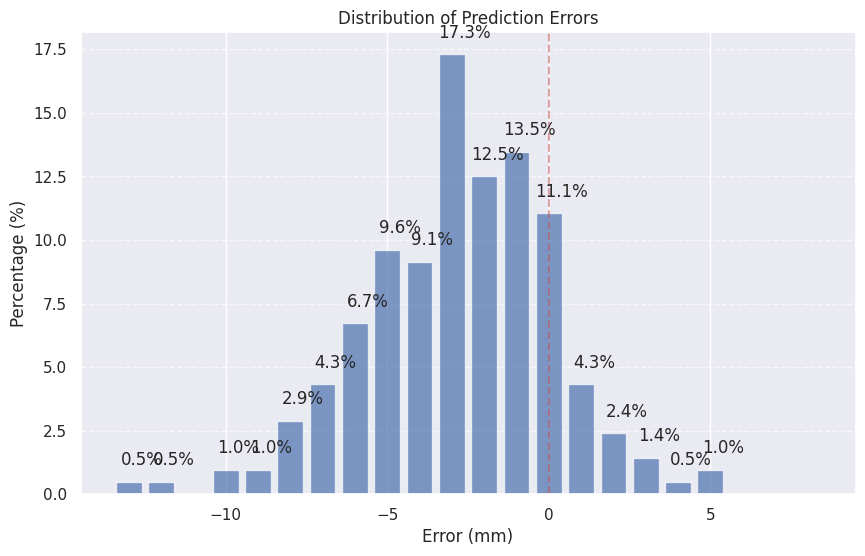

Corrected percentage within ±1mm: 30.77%
Corrected percentage within ±2mm: 50.96%
Corrected percentage within ±3mm: 71.15%


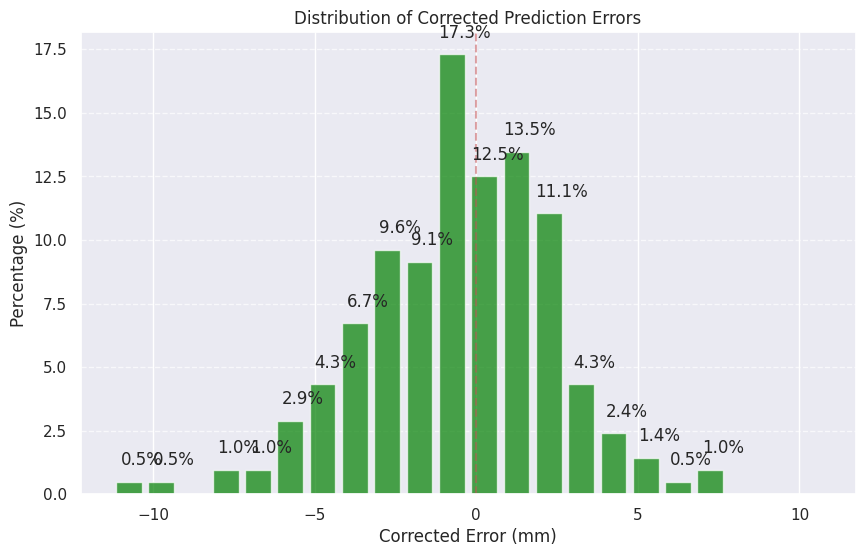

Corrected correlation (r value): 0.6036, p-value: 0.0000


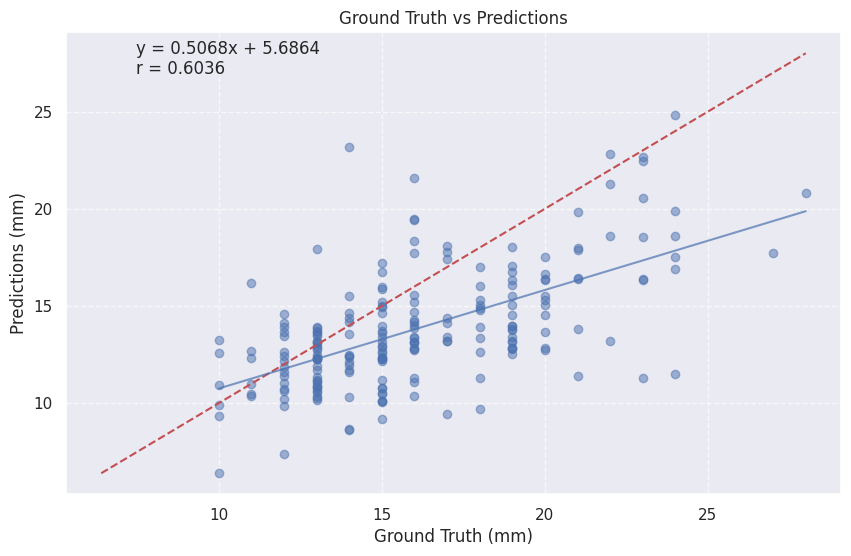

In [13]:
import numpy as np
import statistics
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import math

def my_round(x, d=0):
    p = 10 ** d
    return float(math.floor((x * p) + math.copysign(0.5, x)))/p

model.eval() # prep model for evaluation

outputs, targets, errors = [], [], []
for image_tensor, target in test_loader:
    target = target.view(len(target), 1)
    image_tensor = image_tensor.to(device)
    target = target.to(device)
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(image_tensor)

    outputs.append(output[0].item())
    targets.append(target[0].item())
    #print('estimate R:'+str(my_round(output[0,0].item()))+'mm, L:'+str(my_round(output[0,1].item()))+'mm / target R:'+str(target[0,0].item())+'mm, L:'+str(target[0,1].item())+'mm')

    errors.append(output[0].item()-target[0].item())

AbsError = [abs(i) for i in errors]

print('AveError: '+str(statistics.mean(errors)))
print('StdError: '+str(statistics.stdev(errors)))
print('AveAbsError: '+str(statistics.mean(AbsError)))
print('StdAbsError: '+str(statistics.stdev(AbsError)))

#平均からの差分を補正
corrected_output = (np.array(outputs)-np.array(statistics.mean(errors))).tolist()
corrected_error = (np.array(corrected_output)-np.array(targets)).tolist()
corrected_AbsError = [abs(i) for i in corrected_error]

round_output = [my_round(i) for i in outputs]
round_corrected_AbsError = [my_round(i) for i in corrected_AbsError]

print('Corrected_AveAbsError: '+str(statistics.mean(corrected_AbsError)))
print('Corrected_StdAbsError: '+str(statistics.stdev(corrected_AbsError)))

# Calculate correlation (r value) between ground truth and predictions
correlation, p_value = pearsonr(targets, outputs)
print(f'Correlation (r value): {correlation:.4f}, p-value: {p_value:.4f}')

# Create histogram of errors in 1mm bins
plt.figure(figsize=(10, 6))
bins = np.arange(min(errors) - 0.5, max(errors) + 0.5, 1.0)  # 1mm bins
hist, bin_edges = np.histogram(errors, bins=bins)

# Calculate percentages for each bin
percentages = hist / len(errors) * 100

# Plot histogram with percentage labels
plt.bar(bin_edges[:-1], percentages, width=0.8, alpha=0.7)
plt.xlabel('Error (mm)')
plt.ylabel('Percentage (%)')
plt.title('Distribution of Prediction Errors')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add percentage labels above each bar
for i in range(len(hist)):
    if percentages[i] > 0:
        plt.text(bin_edges[i] + 0.4, percentages[i] + 0.5, f'{percentages[i]:.1f}%',
                 ha='center', va='bottom')

# Add vertical line at zero
plt.axvline(x=0, color='r', linestyle='--', alpha=0.5)

# Calculate percentage within certain error ranges
within_1mm = sum(1 for e in errors if abs(e) <= 1) / len(errors) * 100
within_2mm = sum(1 for e in errors if abs(e) <= 2) / len(errors) * 100
within_3mm = sum(1 for e in errors if abs(e) <= 3) / len(errors) * 100

print(f'Percentage within ±1mm: {within_1mm:.2f}%')
print(f'Percentage within ±2mm: {within_2mm:.2f}%')
print(f'Percentage within ±3mm: {within_3mm:.2f}%')

plt.savefig('error_distribution.png')
plt.show()

# Also create histogram for corrected errors
plt.figure(figsize=(10, 6))
corrected_bins = np.arange(min(corrected_error) - 0.5, max(corrected_error) + 0.5, 1.0)  # 1mm bins
corrected_hist, corrected_bin_edges = np.histogram(corrected_error, bins=corrected_bins)

# Calculate percentages for each bin
corrected_percentages = corrected_hist / len(corrected_error) * 100

# Plot histogram with percentage labels
plt.bar(corrected_bin_edges[:-1], corrected_percentages, width=0.8, alpha=0.7, color='green')
plt.xlabel('Corrected Error (mm)')
plt.ylabel('Percentage (%)')
plt.title('Distribution of Corrected Prediction Errors')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add percentage labels above each bar
for i in range(len(corrected_hist)):
    if corrected_percentages[i] > 0:
        plt.text(corrected_bin_edges[i] + 0.4, corrected_percentages[i] + 0.5, f'{corrected_percentages[i]:.1f}%',
                 ha='center', va='bottom')

# Add vertical line at zero
plt.axvline(x=0, color='r', linestyle='--', alpha=0.5)

# Calculate percentage within certain error ranges for corrected errors
corrected_within_1mm = sum(1 for e in corrected_error if abs(e) <= 1) / len(corrected_error) * 100
corrected_within_2mm = sum(1 for e in corrected_error if abs(e) <= 2) / len(corrected_error) * 100
corrected_within_3mm = sum(1 for e in corrected_error if abs(e) <= 3) / len(corrected_error) * 100

print(f'Corrected percentage within ±1mm: {corrected_within_1mm:.2f}%')
print(f'Corrected percentage within ±2mm: {corrected_within_2mm:.2f}%')
print(f'Corrected percentage within ±3mm: {corrected_within_3mm:.2f}%')

plt.savefig('corrected_error_distribution.png')
plt.show()

# Calculate correlation for corrected outputs as well
corrected_correlation, corrected_p_value = pearsonr(targets, corrected_output)
print(f'Corrected correlation (r value): {corrected_correlation:.4f}, p-value: {corrected_p_value:.4f}')

# Create scatter plot of ground truth vs predictions
plt.figure(figsize=(10, 6))
plt.scatter(targets, outputs, alpha=0.5)
plt.xlabel('Ground Truth (mm)')
plt.ylabel('Predictions (mm)')
plt.title('Ground Truth vs Predictions')
plt.grid(True, linestyle='--', alpha=0.7)

# Add identity line (y=x)
min_val = min(min(targets), min(outputs))
max_val = max(max(targets), max(outputs))
plt.plot([min_val, max_val], [min_val, max_val], 'r--')

# Add regression line
z = np.polyfit(targets, outputs, 1)
p = np.poly1d(z)
plt.plot(sorted(targets), p(sorted(targets)), "b-", alpha=0.7)
plt.text(min_val + (max_val-min_val)*0.05, max_val - (max_val-min_val)*0.05,
         f'y = {z[0]:.4f}x + {z[1]:.4f}\nr = {correlation:.4f}',
         fontsize=12)

plt.savefig('scatter_plot.png')
plt.show()

In [14]:
def my_round(x, d=0):
    p = 10 ** d
    return float(math.floor((x * p) + math.copysign(0.5, x)))/p



model.eval() # prep model for evaluation

outputs,targets,errors =[], [], []
for image_tensor, target in test_loader:
      target = target.view(len(target), 1)
      image_tensor = image_tensor.to(device)
      target = target.to(device)
      # forward pass: compute predicted outputs by passing inputs to the model
      output = model(image_tensor)


      outputs.append(output[0].item())
      targets.append(target[0].item())
      #print('estimate R:'+str(my_round(output[0,0].item()))+'mm, L:'+str(my_round(output[0,1].item()))+'mm / target R:'+str(target[0,0].item())+'mm, L:'+str(target[0,1].item())+'mm')

      errors.append(output[0].item()-target[0].item())

AbsError = [abs(i) for i in errors]

print('AveError: '+str(statistics.mean(errors)))
print('StdError: '+str(statistics.stdev(errors)))
print('AveAbsError: '+str(statistics.mean(AbsError)))
print('StdAbsError: '+str(statistics.stdev(AbsError)))


#平均からの差分を補正
corrected_output = (np.array(outputs)-np.array(statistics.mean(errors))).tolist()
corrected_error = (np.array(corrected_output)-np.array(targets)).tolist()
corrected_AbsError = [abs(i) for i in corrected_error]

round_output = [my_round(i) for i in outputs]
round_corrected_AbsError = [my_round(i) for i in corrected_AbsError]

print('Corrected_AveAbsError: '+str(statistics.mean(corrected_AbsError)))
print('Corrected_StdAbsError: '+str(statistics.stdev(corrected_AbsError)))


AveError: -2.241077872423025
StdError: 3.0250434758633524
AveAbsError: 2.9508120738542996
StdAbsError: 2.334143290561917
Corrected_AveAbsError: 2.3114894714933882
Corrected_StdAbsError: 1.9447603809145135


(10.0, 24.0)

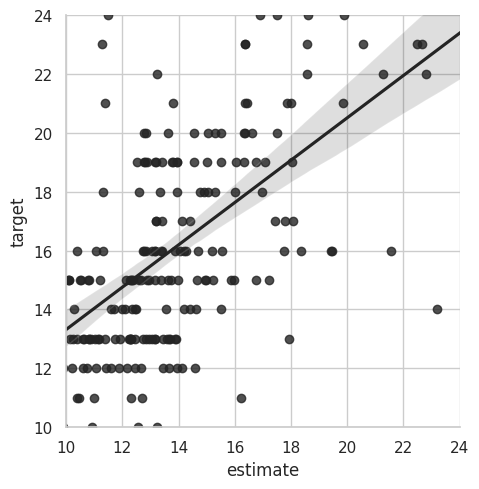

In [15]:
#Draw Graphs（もともとの散布図
df = pd.DataFrame({'estimate':outputs, 'target':targets})

sns.set_style('whitegrid')
sns.set_palette('gray')
sns.lmplot(x='estimate', y='target', data=df)
plt.xlim(10,24)
plt.ylim(10,24)

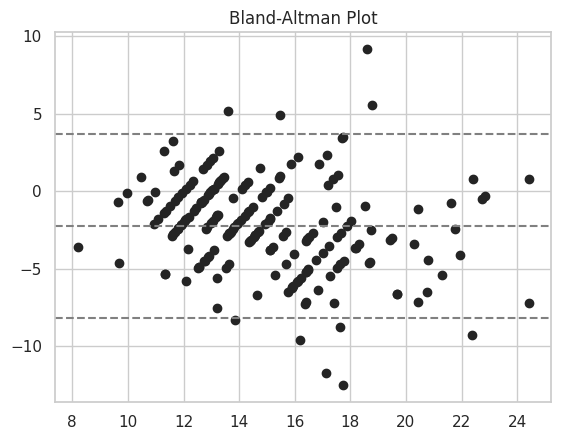

In [16]:
#Bland-Altman-Plot

def bland_altman_plot(data1, data2, *args, **kwargs):
    data1     = np.asarray(data1)
    data2     = np.asarray(data2)
    mean      = np.mean([data1, data2], axis=0)
    diff      = data1 - data2                   # Difference between data1 and data2
    md        = np.mean(diff)                   # Mean of the difference
    sd        = np.std(diff, axis=0)            # Standard deviation of the difference
    plt.scatter(mean, diff, *args, **kwargs)
    plt.axhline(md,           color='gray', linestyle='--')
    plt.axhline(md + 1.96*sd, color='gray', linestyle='--')
    plt.axhline(md - 1.96*sd, color='gray', linestyle='--')

bland_altman_plot(outputs, targets)
plt.title('Bland-Altman Plot')
plt.show()

In [17]:
from sklearn import linear_model

estimate = df.loc[:,'estimate']
target = df.loc[:,'target']
clf = linear_model.LinearRegression()

# 説明変数xに "x1"のデータを使用
x = np.array([estimate]).T

# 目的変数yに "x2"のデータを使用
y = target.values

# 予測モデルを作成（単回帰）
clf.fit(x, y)

# パラメータ（回帰係数、切片）を抽出
[a] = clf.coef_
b = clf.intercept_

# パラメータの表示
print("回帰係数:", a)
print("切片:", b)
print("決定係数:", clf.score(x, y))

#平均値により補正した値
df['Corrected_estimate_1']=0
for i in range(len(df)):
    df.iloc[i,2] = corrected_output[i]

#回帰直線により補正した値
df['Corrected_estimate_2']=0
for i in range(len(df)):
    df.iloc[i,3] = df.iloc[i,0]*a+b

#残差
df['Residual_error_1']=0
for i in range(len(df)):
    df.iloc[i,4] = df.iloc[i,2]-df.iloc[i,1]

#残差
df['Residual_error_2']=0
for i in range(len(df)):
    df.iloc[i,5] = df.iloc[i,3]-df.iloc[i,1]


回帰係数: 0.7189474839051092
切片: 6.128325765427505
決定係数: 0.36433015385674095


<ipython-input-17-1bca9812ba81>:28: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '15.605432006028982' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.iloc[i,2] = corrected_output[i]
<ipython-input-17-1bca9812ba81>:33: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '15.736594543800352' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.iloc[i,3] = df.iloc[i,0]*a+b
<ipython-input-17-1bca9812ba81>:38: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-0.3945679939710178' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.iloc[i,4] = df.iloc[i,2]-df.iloc[i,1]
<ipython-input-17-1bca9812ba81>:43: FutureWarning: Setting an item of

In [18]:
print(df)

      estimate  target  Corrected_estimate_1  Corrected_estimate_2  \
0    13.364354    16.0             15.605432             15.736595   
1    13.167535    16.0             15.408613             15.595092   
2    18.077019    17.0             20.318097             19.124753   
3    17.413837    17.0             19.654915             18.647960   
4    15.309819    18.0             17.550897             17.135282   
..         ...     ...                   ...                   ...   
203  13.950415    19.0             16.191493             16.157941   
204  12.693309    11.0             14.934387             15.254148   
205  16.204681    11.0             18.445759             17.778641   
206  13.387380    15.0             15.628458             15.753149   
207  14.123834    17.0             16.364912             16.282620   

     Residual_error_1  Residual_error_2  
0           -0.394568         -0.263405  
1           -0.591387         -0.404908  
2            3.318097          2.

<ipython-input-19-f12c8eecf5a3>:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(


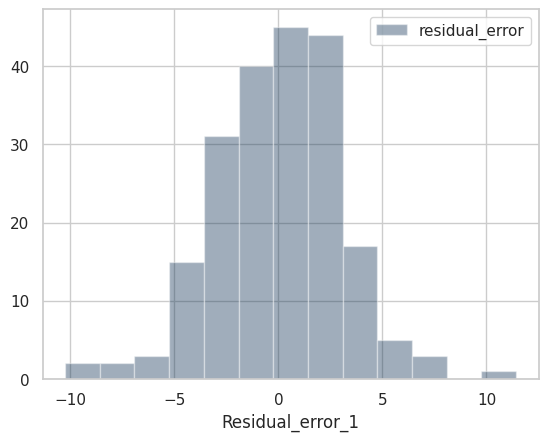

AveError: 6.063525749875855e-16
StdError: 3.025043475863353
AveAbsError: 2.3114894714933882
StdAbsError: 1.9447603809145135


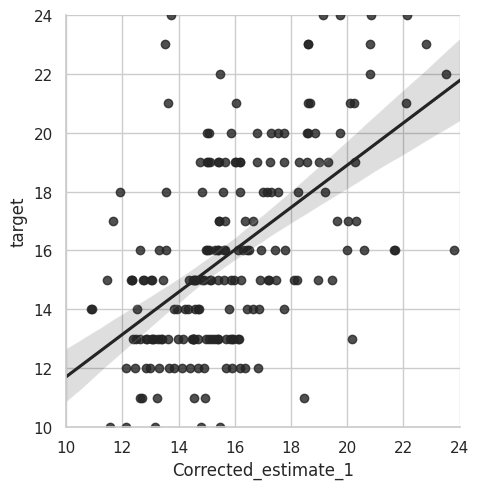

In [19]:
#平均近似バージョン
#Draw histogram
sns.distplot(
    df['Residual_error_1'], bins=13, color='#123456', label='residual_error',
    kde=False,
    rug=False
)
plt.legend() # 凡例を表示
plt.show()   # ヒストグラムを表示


#Draw Graphs
sns.set_style('whitegrid')
sns.set_palette('gray')
sns.lmplot(x='Corrected_estimate_1', y='target', data=df)
plt.xlim(10,24)
plt.ylim(10,24)

corrected_AbsError = [abs(i) for i in df['Residual_error_1']]
print('AveError: '+str(statistics.mean(df['Residual_error_1'])))
print('StdError: '+str(statistics.stdev(df['Residual_error_1'])))
print('AveAbsError: '+str(statistics.mean(corrected_AbsError)))
print('StdAbsError: '+str(statistics.stdev(corrected_AbsError)))


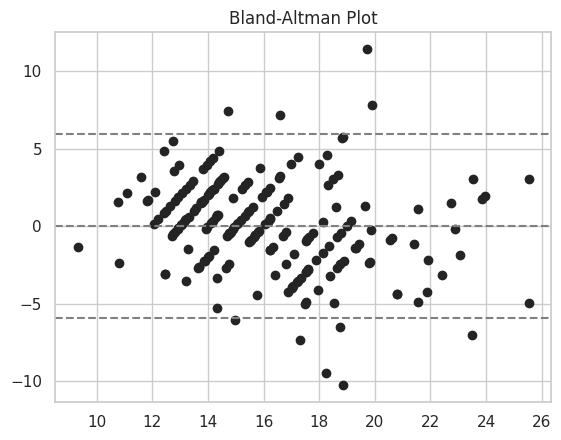

In [20]:
#Bland-Altman-Plot using corrected value (平均値により補正)

def bland_altman_plot(data1, data2, *args, **kwargs):
    data1     = np.asarray(data1)
    data2     = np.asarray(data2)
    mean      = np.mean([data1, data2], axis=0)
    diff      = data1 - data2                   # Difference between data1 and data2
    md        = np.mean(diff)                   # Mean of the difference
    sd        = np.std(diff, axis=0)            # Standard deviation of the difference
    plt.scatter(mean, diff, *args, **kwargs)
    plt.axhline(md,           color='gray', linestyle='--')
    plt.axhline(md + 1.96*sd, color='gray', linestyle='--')
    plt.axhline(md - 1.96*sd, color='gray', linestyle='--')


corrected_estimate = df.loc[:,'Corrected_estimate_1']
target = df.loc[:,'target']

bland_altman_plot(corrected_estimate, target)
plt.title('Bland-Altman Plot')
plt.show()


<ipython-input-21-1af5f8d72b71>:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(


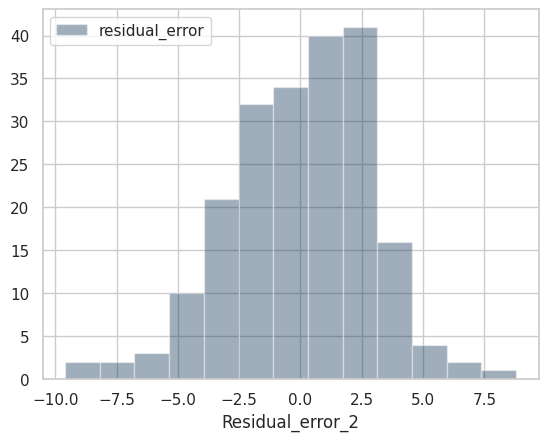

AveError: -1.955700558762776e-15
StdError: 2.9006774359909104
AveAbsError: 2.2871510029015836
StdAbsError: 1.7769634373665804

-1<Error<1: 56
-2<Error<2: 107
Error<=-2: 48
Error>=2: 53

Hertel 18mm以上の検出精度
TP: 23
FP: 12
FN: 44
TN: 129
Sensitivity: 0.34328358208955223
Specificity: 0.9148936170212766
Positive predictive value: 0.6571428571428571
Negative predictive value: 0.7456647398843931

推測18mm以上だが実は16mm未満(過剰): 4例
推測16mm未満だが実は18mm以上（見逃がし）: 18例


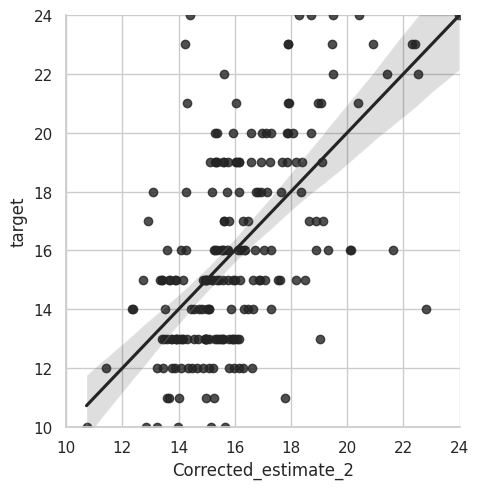

In [21]:
#線形近似バージョン
#Draw histogram
sns.distplot(
    df['Residual_error_2'], bins=13, color='#123456', label='residual_error',
    kde=False,
    rug=False
)
plt.legend() # 凡例を表示
plt.show()   # ヒストグラムを表示


#Draw Graphs
sns.set_style('whitegrid')
sns.set_palette('gray')
sns.lmplot(x='Corrected_estimate_2', y='target', data=df)
plt.xlim(10,24)
plt.ylim(10,24)

corrected_AbsError = [abs(i) for i in df['Residual_error_2']]
print('AveError: '+str(statistics.mean(df['Residual_error_2'])))
print('StdError: '+str(statistics.stdev(df['Residual_error_2'])))
print('AveAbsError: '+str(statistics.mean(corrected_AbsError)))
print('StdAbsError: '+str(statistics.stdev(corrected_AbsError)))

print('')
print('-1<Error<1: '+ str(sum((i < 1 and i > -1 for i in df['Residual_error_2']))))
print('-2<Error<2: '+ str(sum((i < 2 and i > -2 for i in df['Residual_error_2']))))
print('Error<=-2: ' +  str(sum((i <= -2 for i in df['Residual_error_2']))))
print('Error>=2: ' +  str(sum((i >= 2 for i in df['Residual_error_2']))))


TP, FP, TN, FN = 0,0,0,0
for i in range(len(df)):
    if df.iloc[i,1]>=18 and df.iloc[i,3]>= 18:
        TP += 1
    if df.iloc[i,1]<18 and df.iloc[i,3]>= 18:
        FP += 1
    if df.iloc[i,1]>=18 and df.iloc[i,3]< 18:
        FN += 1
    if df.iloc[i,1]<18 and df.iloc[i,3]< 18:
        TN += 1

print('')
print('Hertel 18mm以上の検出精度')
print('TP: '+str(TP))
print('FP: '+str(FP))
print('FN: '+str(FN))
print('TN: '+str(TN))
print('Sensitivity: '+str(TP/(TP+FN)))
print('Specificity: '+str(TN/(FP+TN)))
print('Positive predictive value: '+str(TP/(TP+FP)))
print('Negative predictive value: '+str(TN/(TN+FN)))


okpositive, minogashi, oknegative, kajyou = 0,0,0,0
for i in range(len(df)):
    if df.iloc[i,1]>=16 and df.iloc[i,3]> 18:
        okpositive += 1
    if df.iloc[i,1]<16 and df.iloc[i,3]>= 18:
        kajyou += 1
    if df.iloc[i,1]>=18 and df.iloc[i,3]<= 16:
        minogashi += 1
    if df.iloc[i,1]<18 and df.iloc[i,3]<= 16:
        oknegative += 1

print('')
print('推測18mm以上だが実は16mm未満(過剰): '+str(kajyou)+'例')
print('推測16mm未満だが実は18mm以上（見逃がし）: '+str(minogashi)+'例')

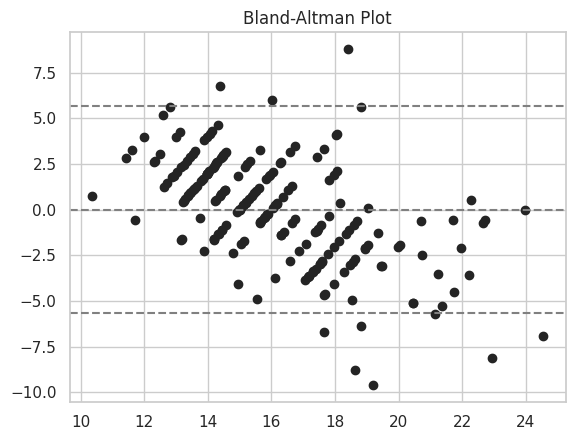

In [22]:
#Bland-Altman-Plot using corrected value (線形近似により補正)

def bland_altman_plot(data1, data2, *args, **kwargs):
    data1     = np.asarray(data1)
    data2     = np.asarray(data2)
    mean      = np.mean([data1, data2], axis=0)
    diff      = data1 - data2                   # Difference between data1 and data2
    md        = np.mean(diff)                   # Mean of the difference
    sd        = np.std(diff, axis=0)            # Standard deviation of the difference
    plt.scatter(mean, diff, *args, **kwargs)
    plt.axhline(md,           color='gray', linestyle='--')
    plt.axhline(md + 1.96*sd, color='gray', linestyle='--')
    plt.axhline(md - 1.96*sd, color='gray', linestyle='--')


corrected_estimate = df.loc[:,'Corrected_estimate_2']
target = df.loc[:,'target']

bland_altman_plot(corrected_estimate, target)
plt.title('Bland-Altman Plot')
plt.show()
